### Name: Janhavi Welekar


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
import warnings
import
warnings.filterwarnings('ignore')

In [3]:
uploaded = files.upload()

Saving SupplyChainEmission.csv to SupplyChainEmission.csv


In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("mako")

In [6]:
df = pd.read_csv("SupplyChainEmission.csv")
print(f"📦 Dataset loaded. Shape: {df.shape}")
df.head()

📦 Dataset loaded. Shape: (1016, 8)


,2017 NAICS Code,2017 NAICS Title,GHG,Unit,Supply Chain Emission Factors without Margins,Margins of Supply Chain Emission Factors,Supply Chain Emission Factors with Margins,Reference USEEIO Code
0,111110,Soybean Farming,All GHGs,"kg CO2e/2021 USD, purchaser price",1.223,0.103,1.326,1111A0
1,111120,Oilseed (except Soybean) Farming,All GHGs,"kg CO2e/2021 USD, purchaser price",1.223,0.103,1.326,1111A0
2,111130,Dry Pea and Bean Farming,All GHGs,"kg CO2e/2021 USD, purchaser price",2.874,0.134,3.007,1111B0
3,111140,Wheat Farming,All GHGs,"kg CO2e/2021 USD, purchaser price",2.874,0.134,3.007,1111B0
4,111150,Corn Farming,All GHGs,"kg CO2e/2021 USD, purchaser price",2.874,0.134,3.007,1111B0


In [9]:
print(df.columns.tolist())



['2017 NAICS Code', '2017 NAICS Title', 'GHG', 'Unit', 'Supply Chain Emission Factors without Margins', 'Margins of Supply Chain Emission Factors', 'Supply Chain Emission Factors with Margins', 'Reference USEEIO Code']


In [10]:
# Drop unnecessary columns
df = df.drop(columns=[
    "2017 NAICS Code",        # like "Industry Code"
    "2017 NAICS Title",       # like "Industry Name"
    "GHG",                    # like "Substance"
    "Unit",                   # same
    "Reference USEEIO Code"   # replaces "Unnamed: 7"
], errors='ignore')

# Set target variable
target = "Margins of Supply Chain Emission Factors"
X = df.drop(columns=[target])
y = df[target]

# Handle missing values
X = X.fillna(X.mean(numeric_only=True))  # Prevent issues if any string column is left

# Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
print("Training features:", X.columns.tolist())


Training features: ['Supply Chain Emission Factors without Margins', 'Supply Chain Emission Factors with Margins']


In [12]:
# Initialize models
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)

# Train models
lr_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [13]:
def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print(f"📊 {name} Performance:")
    print(f"  ✅ RMSE: {rmse:.4f}")
    print(f"  ✅ MAE : {mae:.4f}")
    print(f"  ✅ R²  : {r2:.4f}\n")
    return rmse, mae, r2

# Evaluate all models
evaluate_model("Linear Regression", lr_model, X_test, y_test)
evaluate_model("Decision Tree", dt_model, X_test, y_test)
evaluate_model("Random Forest", rf_model, X_test, y_test)


📊 Linear Regression Performance:
  ✅ RMSE: 0.0003
  ✅ MAE : 0.0001
  ✅ R²  : 0.9999

📊 Decision Tree Performance:
  ✅ RMSE: 0.0116
  ✅ MAE : 0.0028
  ✅ R²  : 0.9318

📊 Random Forest Performance:
  ✅ RMSE: 0.0149
  ✅ MAE : 0.0048
  ✅ R²  : 0.8874



(np.float64(0.014892910138004483), 0.004750267156862742, 0.8874260643450065)

In [14]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_

print("🔍 Best Parameters:", grid_search.best_params_)
evaluate_model("Tuned Random Forest", best_rf_model, X_test, y_test)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
🔍 Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
📊 Tuned Random Forest Performance:
  ✅ RMSE: 0.0152
  ✅ MAE : 0.0049
  ✅ R²  : 0.8821



(np.float64(0.015239286733450999), 0.004862655228758172, 0.8821287219208076)

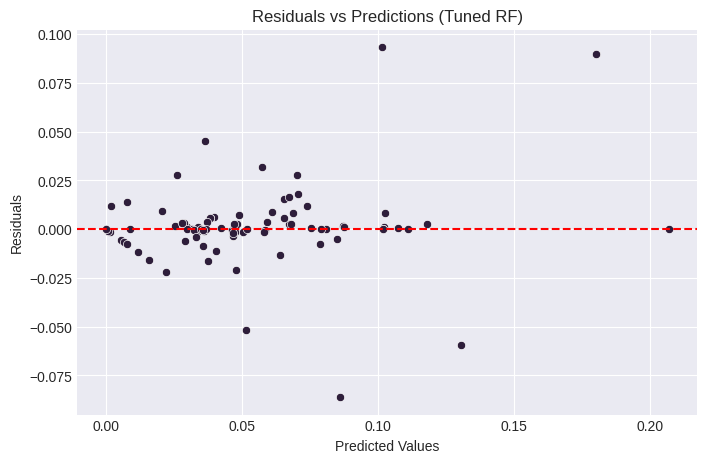

In [19]:
# Residuals vs Predictions Plot
predictions = best_rf_model.predict(X_test)
residuals = y_test - predictions

plt.figure(figsize=(8, 5))
sns.scatterplot(x=predictions, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predictions (Tuned RF)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()



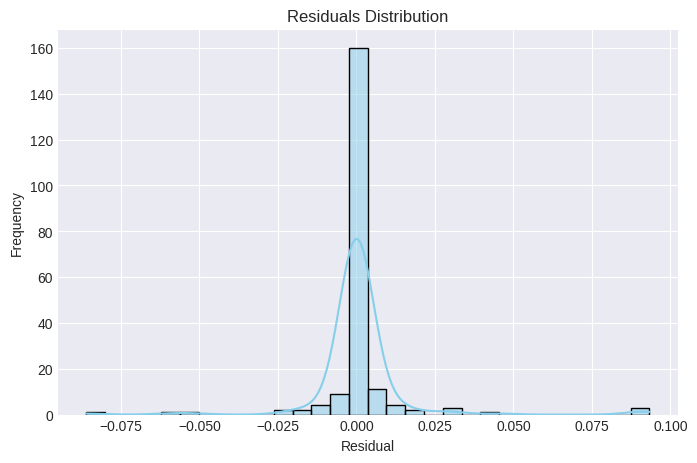

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


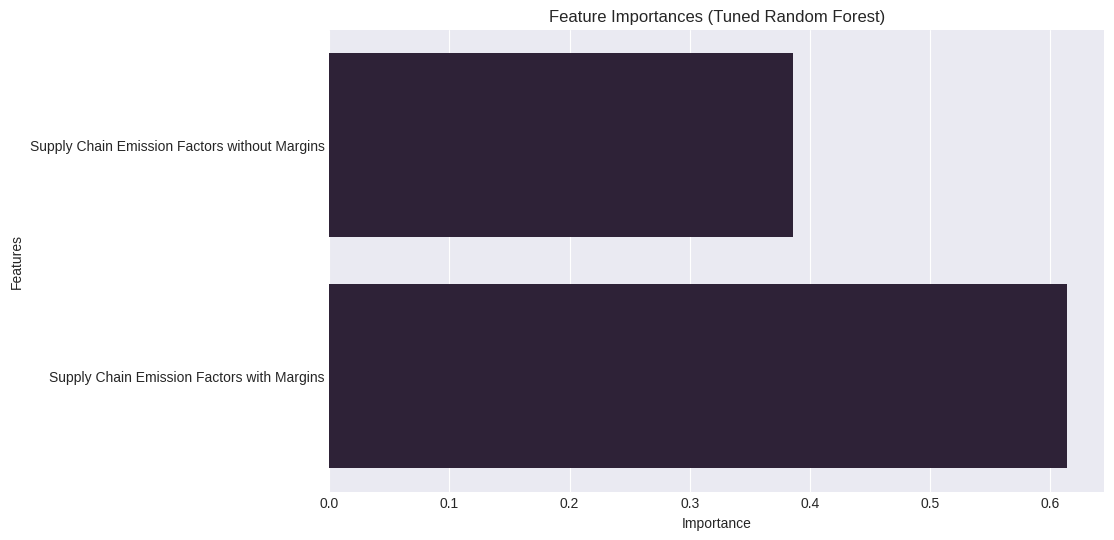

In [21]:
importances = best_rf_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances (Tuned Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


In [22]:
joblib.dump(best_rf_model, "best_random_forest_model.pkl")
print("✅ Model saved as best_random_forest_model.pkl")


✅ Model saved as best_random_forest_model.pkl
